In [21]:
import bs4
import os
import re

import pandas as pd
import sklearn as sk

# from sklearn import model_selection
from sklearn.metrics import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

random_state_all = 1

In [22]:
def parser(path : str) -> list:
    filenames = [html for html in os.listdir(path) if '.html' in html]      # Собираем имена файлов с разрешением html в папке, переданной в параметр path
    messages_all = []                                                       # Переменная для хранения сообщений

    for file in filenames:                                                  # Перебираем имена файлов, собранных ранее
        with open(f'{path}\{file}', "rb") as html_file:                      # Открываем файл на чтение
            index = html_file.read()                                        # Записываем содержимое файла (html-разметку страницы) в переменную

        page = bs4.BeautifulSoup(index)                                     # Создаем объект bs4, позволяющий парсить html

        messages = page.find_all('div', class_='text')                      # Собираем все элементы div с классом text (сообщения) в список

        for name in messages:                                               # Перебираем каждое сообщение
            messages_all.append(name.text.strip())                          # Дополняем список всех сообщений чата взятым на этой итерации сообщением с убранными пробелами по краям
    
    return(messages_all)                                                    # Возвращаем результат работы

In [23]:
def balancer(df1 : pd.DataFrame, df2 : pd.DataFrame) -> pd.DataFrame:           # Функция принимаем на вход два объекта типа DataFrame и его же возвращает
    if len(df1) > len(df2):                                                     # Если количество элементов первого датафрейма больше, чем у второго
        return(df1.sample(n = len(df2)).reset_index().drop('index', axis = 1))  # Возвращаем датафрейм, собранным из случайных элементов первого датафрейма

    elif len(df1) < len(df2):                                                   # Если количество элементов второго датафрейма больше, чем у первого
        return(df2.sample(n = len(df1)).reset_index().drop('index', axis = 1))  # Возвращаем датафрейм, собранным из случайных элементов второго датафрейма

In [24]:
petersburg_transport = parser('K:\Downloads\Telegram Desktop\Транспорт Петербурга. Организатор перевозок')
moscow_transport = parser('K:\Downloads\Telegram Desktop\Дептранс Москвы')

In [25]:
petersburg_df = pd.DataFrame(petersburg_transport, columns = ['text']).dropna().drop_duplicates()   # Создаем датафрейм из данных парсера со столбцом text, удаляем пустые значения и дубликаты
petersburg_df['y'] = petersburg_transport[0]                                                        # Первая строка - название канала.
petersburg_df['text'] = petersburg_df['text'].apply(lambda x: re.sub('[^\w\s#@/:%.,!?_-]', '', x))  # Замена символов, формирующих смайлики, на пустоту
petersburg_df = pd.DataFrame(petersburg_df.loc()[1:])                                               # Убираем первую строку из датафрейма

In [26]:
moscow_df = pd.DataFrame(moscow_transport, columns = ['text']).dropna().drop_duplicates()   # Создаем датафрейм из данных парсера со столбцом text, удаляем пустые значения и дубликаты
moscow_df['y'] = moscow_transport[0]                                                        # Первая строка - название канала.
moscow_df['text'] = moscow_df['text'].apply(lambda x: re.sub('[^\w\s#@/:%.,!?_-]', '', x))  # Замена символов, формирующих смайлики, на пустоту
moscow_df = pd.DataFrame(moscow_df.loc()[1:])                                               # Убираем первую строку из датафрейма

Объем данных до балансировки

In [27]:
print(f"Дептранс Москвы - {len(moscow_df)}\nТранспорт Питера - {len(petersburg_df)}")

Дептранс Москвы - 12535
Транспорт Питера - 3604


In [28]:
moscow_df = balancer(moscow_df, petersburg_df)

Объем данных после балансировки

In [29]:
print(f"Дептранс Москвы - {len(moscow_df)}\nТранспорт Питера - {len(petersburg_df)}")

Дептранс Москвы - 3604
Транспорт Питера - 3604


In [30]:
transports_df = pd.concat([petersburg_df, moscow_df], ignore_index=True)                    # Создаем объединенный датафрейм по сообщениям из двух городов

In [31]:
transports_df

,text,y
0,Станция Адмиралтейская закрыта на вход и выход.,Транспорт Петербурга. Организатор перевозок
1,Станция Адмиралтейская открыта для пассажиров.,Транспорт Петербурга. Организатор перевозок
2,8 апреля с 9 до 15 часов на Конногвардейском б...,Транспорт Петербурга. Организатор перевозок
3,"8, 9, 10 апреля, работы на теплосети на ул. Се...",Транспорт Петербурга. Организатор перевозок
4,9 апреля с 9:30 до 12:30 на Исаакиевской пл. п...,Транспорт Петербурга. Организатор перевозок
...,...,...
7203,В Москве поэтапно развивается один из крупнейш...,Дептранс Москвы
7204,В Лианозово идет строительство новой станции м...,Дептранс Москвы
7205,Такие плакаты Ночлежки появились в переходах и...,Дептранс Москвы
7206,"- Определены 24 новых автобусных маршрута, кот...",Дептранс Москвы


Передаю мешку слов датафрейм с сообщениями без изменений, поскольку токенизация происходит внутри библиотеки. Если попытаться сделать тоекнизацию и отдать на преобразование векторизатору датафрейм, где в каждой строке столбца text будет массив токенов, то будет выдана ошибка. Объяснения есть ниже.

Выдержка из комментария к библиотеке:

input : {'filename', 'file', 'content'}, default='content'

        * If `'filename'`, the sequence passed as an argument to fit is
          expected to be a list of filenames that need reading to fetch
          the raw content to analyze.

        * If `'file'`, the sequence items must have a 'read' method (file-like
          object) that is called to fetch the bytes in memory.

        * If `'content'`, the input is expected to be a sequence of items that
          can be of type string or byte.

Изо всех вариантов выше видно, что нам максимально подходит только третий, где передаваемая информация должна быть итерируемым массивом из элементов типа строк и байтов.

Точность: 0.9766151407055094
f1-мера: 0.9766151407055094
Предсказание введенного текста: Дептранс Москвы


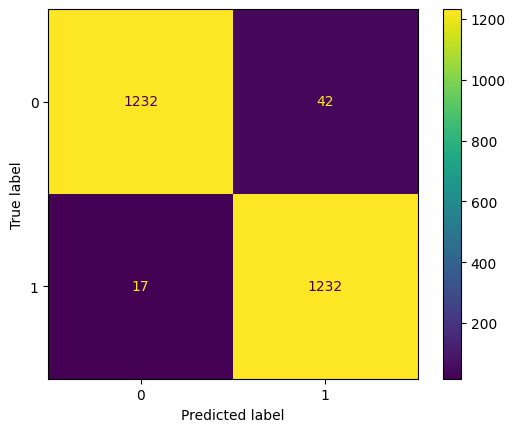

In [35]:
X, y = transports_df.text, transports_df.y                                                                                  # Создаем Х и У из столбцов датафрейма
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.35, random_state=random_state_all) # Разделяем датафрейм на тренировочную и тестовую выборки

vectorizer = CountVectorizer(lowercase = True)                              # Создаем обхект векторизации методом мешка слов с параметром, переводящим текст в нижний регистр
X_train_counts = vectorizer.fit_transform(X_train)                          # Преобразовываем тренировочные фичи в вектора

clf = MultinomialNB()                                                       # Создаем объект Ниавного Байесовского классификатора
clf.fit(X_train_counts, y_train)                                            # Тренируем классификатор на тренироваочных данных ( y не преобразовали, поскольку это лишь указание класса, которому принадлежит каждая строка )

score = clf.score(vectorizer.transform(X_test), y_test)                     # Оцениваем точность модели на тестовых данных ( так же преобразовали фичи и не тронули метки )

new_text = [' '.join('''
🚗 На прошлой неделе количество автомобилей на дорогах города уменьшилось в среднем на 130 тыс. в сутки.

По данным аналитиков ЦОДД, в майские праздники жители Москвы чаще всего ездили в районы:

🔹 Митино (Митинский лесопарк)
🔹 Ивановское (Измайловский парк)
🔹 Бирюлёво Восточное (Бирюлевский лесопарк)
🔹 Строгино (Большой Строгинский затон)
🔹 Чертаново Южное (Битцевский парк)
🔹 Ярославский (Национальный парк Лосиный остров)

Магистрали, по которым больше всего выезжали из города:

🔹 Ярославское шоссе    
🔹 Варшавское шоссе      
🔹 Волоколамское шоссе     
🔹 Ленинский проспект   
🔹 Дмитровское шоссе

В карточке собрали всю интересную статистику 👆🏼

Ожидаем, что к 15 мая в Москву вернутся автомобили, которые уехали после первых и вторых длинных выходных. Планируйте маршруты и время выезда обратно в город заранее.
'''.split('\n'))] # В этой переменной храним текст из одной из двух групп для проверки его принадлежности этим группам
predicted_test = clf.predict(vectorizer.transform(X_test))                  # Предсказываем, каким классам ( группам ) принадлежать сообщения из тестовой выборки
predicted = clf.predict(vectorizer.transform(new_text))[0]                  # Предсказываем какому классу ( какой группе ) принадлежит введенный выше текст

# Преобразовываем объекты Series в датафреймы
y_test_df = pd.DataFrame(y_test).reset_index().drop('index', axis = 1)
y_test_predicted_df = pd.DataFrame(predicted_test.tolist()).rename(columns = {0 : 'y'})


# Выводим оценки качества модели и предсказанный класс
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_predicted_df)).plot()
print(f"Точность: {score}\nf1-мера: {f1_score(y_test_df, y_test_predicted_df, pos_label=y_test_df.loc()[0].tolist()[0])}")                                     
print(f"Предсказание введенного текста: {predicted}")